In [1]:
from jax import vmap
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from aging.behavior.bio_age_model import compute_concentrations, fit_model

In [2]:
def zscore(ser: pd.Series):
    return (ser - ser.mean()) / ser.std()


def demean(ser: pd.Series):
    return ser - ser.mean()

In [3]:
df = pd.read_parquet(
    "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_relabeled_counts_matrix_v00.parquet"
)
df = df.sort_index(axis=1)

n_syllables = 55
age = jnp.array(df.index.get_level_values("age"))
syllable_counts_jax = jnp.array(df.astype(float))[:, :n_syllables]

In [4]:
pth = '/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_mouse_area_df_v00.parquet'
size_df = pd.read_parquet(pth)

In [5]:
sizes_col = size_df.groupby('age')['quant_0.5'].transform(demean)
# sizes_col = size_df.groupby('age')['quant_0.5'].transform(zscore)
# sizes_col = size_df['quant_0.5']
sizes_col = sizes_col.loc[df.index]

In [6]:
features = {
    "ages": age,
    "counts": syllable_counts_jax + 1,
    "sizes": sizes_col.to_numpy(),
}

hypparams = {
    "min_age": 1,
    "max_age": 130,
    "age_sd": 20,  # weeks
    "bio_params_sd": 0.3,
    "size_params_sd": 0.3,
    "n_age_samples": 1000,
    "n_splines": 5,
    "n_size_splines": 5,
    "n_syllables": n_syllables,
    "n_keep_sylls": 15,
    "n_sessions": len(syllable_counts_jax),
    "lr": 0.2,
    "n_opt_iter": 80,
}

output = fit_model(features, hypparams, 2)

In [7]:
total_counts = features['counts'].sum(1)

In [7]:
list(output)

['params',
 'heldout_ll',
 'loss',
 'bio_ages',
 'true_ages',
 'init_components',
 'concentrations',
 'concentration_components',
 'predicted_counts',
 'counts',
 'r2_total',
 'r2_each']

In [8]:
output['r2_total']

0.5322141838772808

In [8]:
output['counts'].shape

(360, 55)

In [9]:
output['predicted_counts'].shape

(360, 55)

In [10]:
r2_score(output['counts'], output['predicted_counts'], multioutput='variance_weighted')

0.5322141838772808

In [11]:
r2_score(output['counts'], output['predicted_counts'], multioutput='raw_values')

array([ 0.68437821,  0.76354666,  0.45717519,  0.36239475,  0.30601385,
        0.67155333,  0.52981888,  0.5270175 ,  0.37130335,  0.52747096,
        0.61681406,  0.47291326,  0.46634348,  0.40531239,  0.69110618,
        0.34631284,  0.18865414,  0.64363804,  0.23715595,  0.31977701,
        0.68617659,  0.1929219 ,  0.54872294,  0.81114044,  0.69559362,
        0.33060641,  0.0462056 ,  0.38785712,  0.13678074,  0.21069578,
        0.21916498,  0.4611638 ,  0.35048237,  0.1764945 ,  0.18676053,
        0.16326784,  0.11343379,  0.16984531,  0.09143444,  0.38787787,
        0.12759573,  0.1691158 ,  0.01034379, -0.09801888,  0.23283602,
        0.08016821,  0.02286968,  0.12163131, -0.03619205,  0.11708503,
        0.0683608 ,  0.18514461,  0.01850461, -0.0902241 ,  0.14771065])

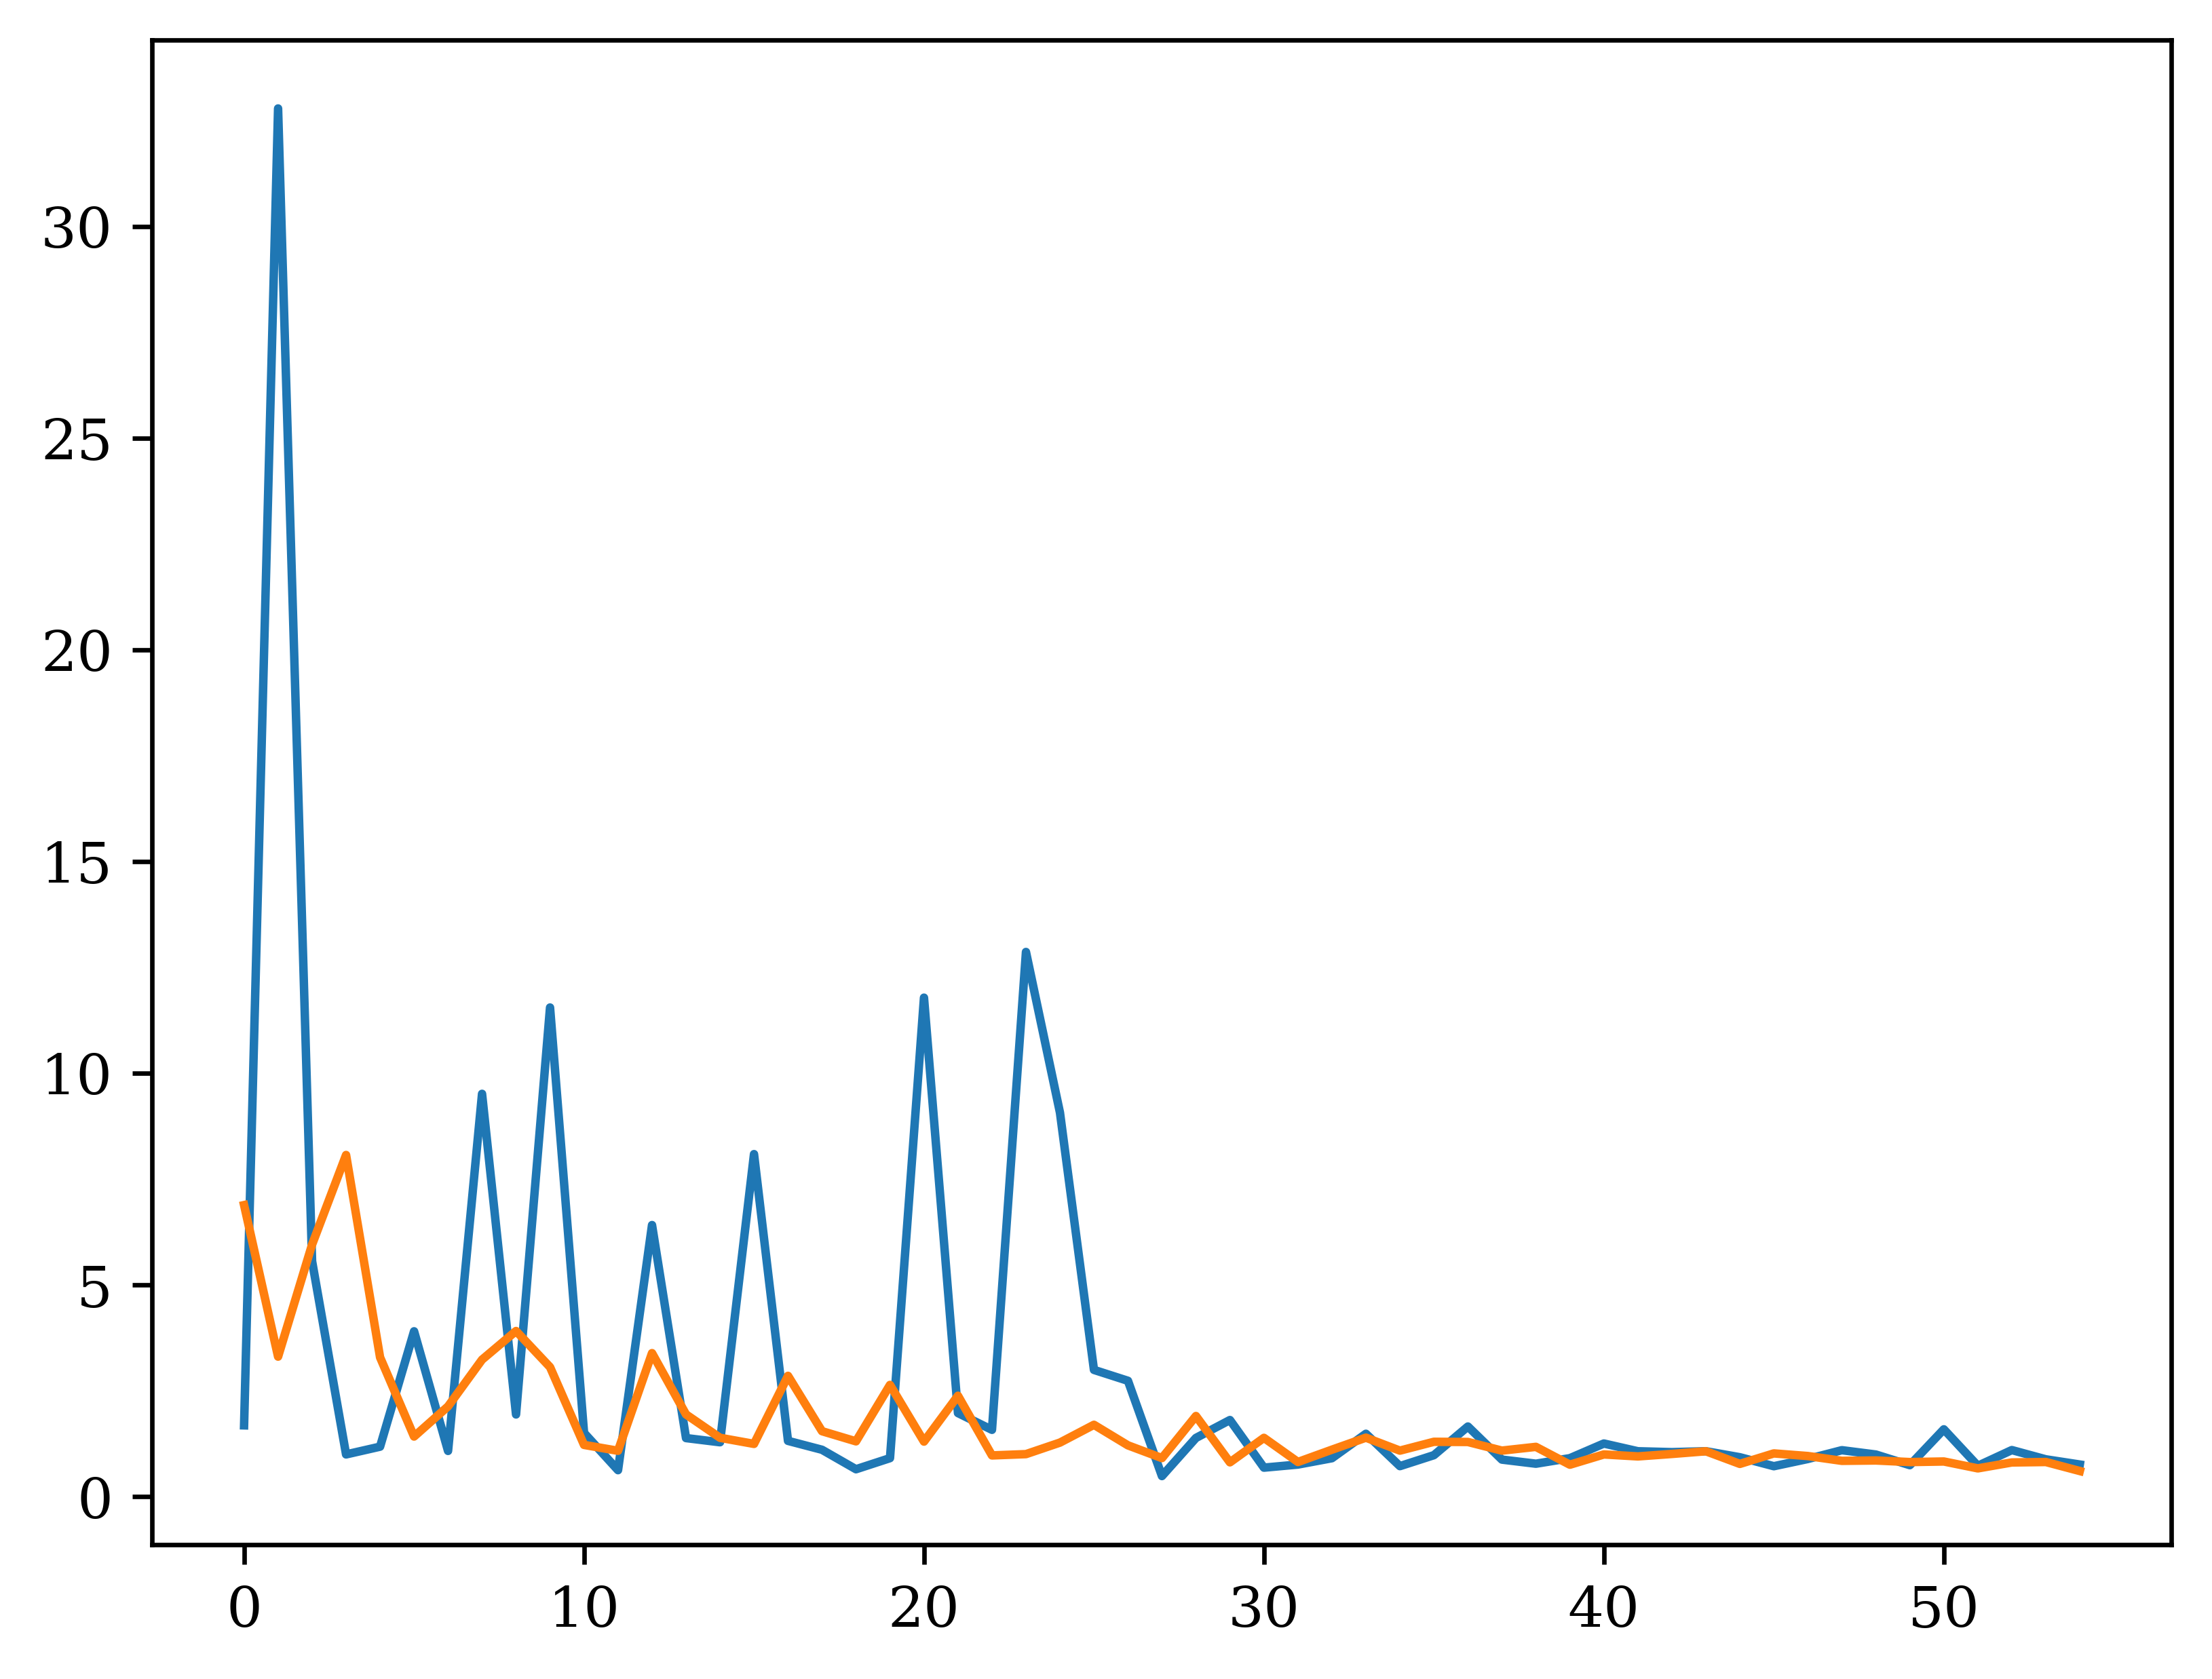

In [43]:
plt.plot(concentration_components['bio'][:, 0])
plt.plot(np.mean(concentration_components['size'], axis=1))

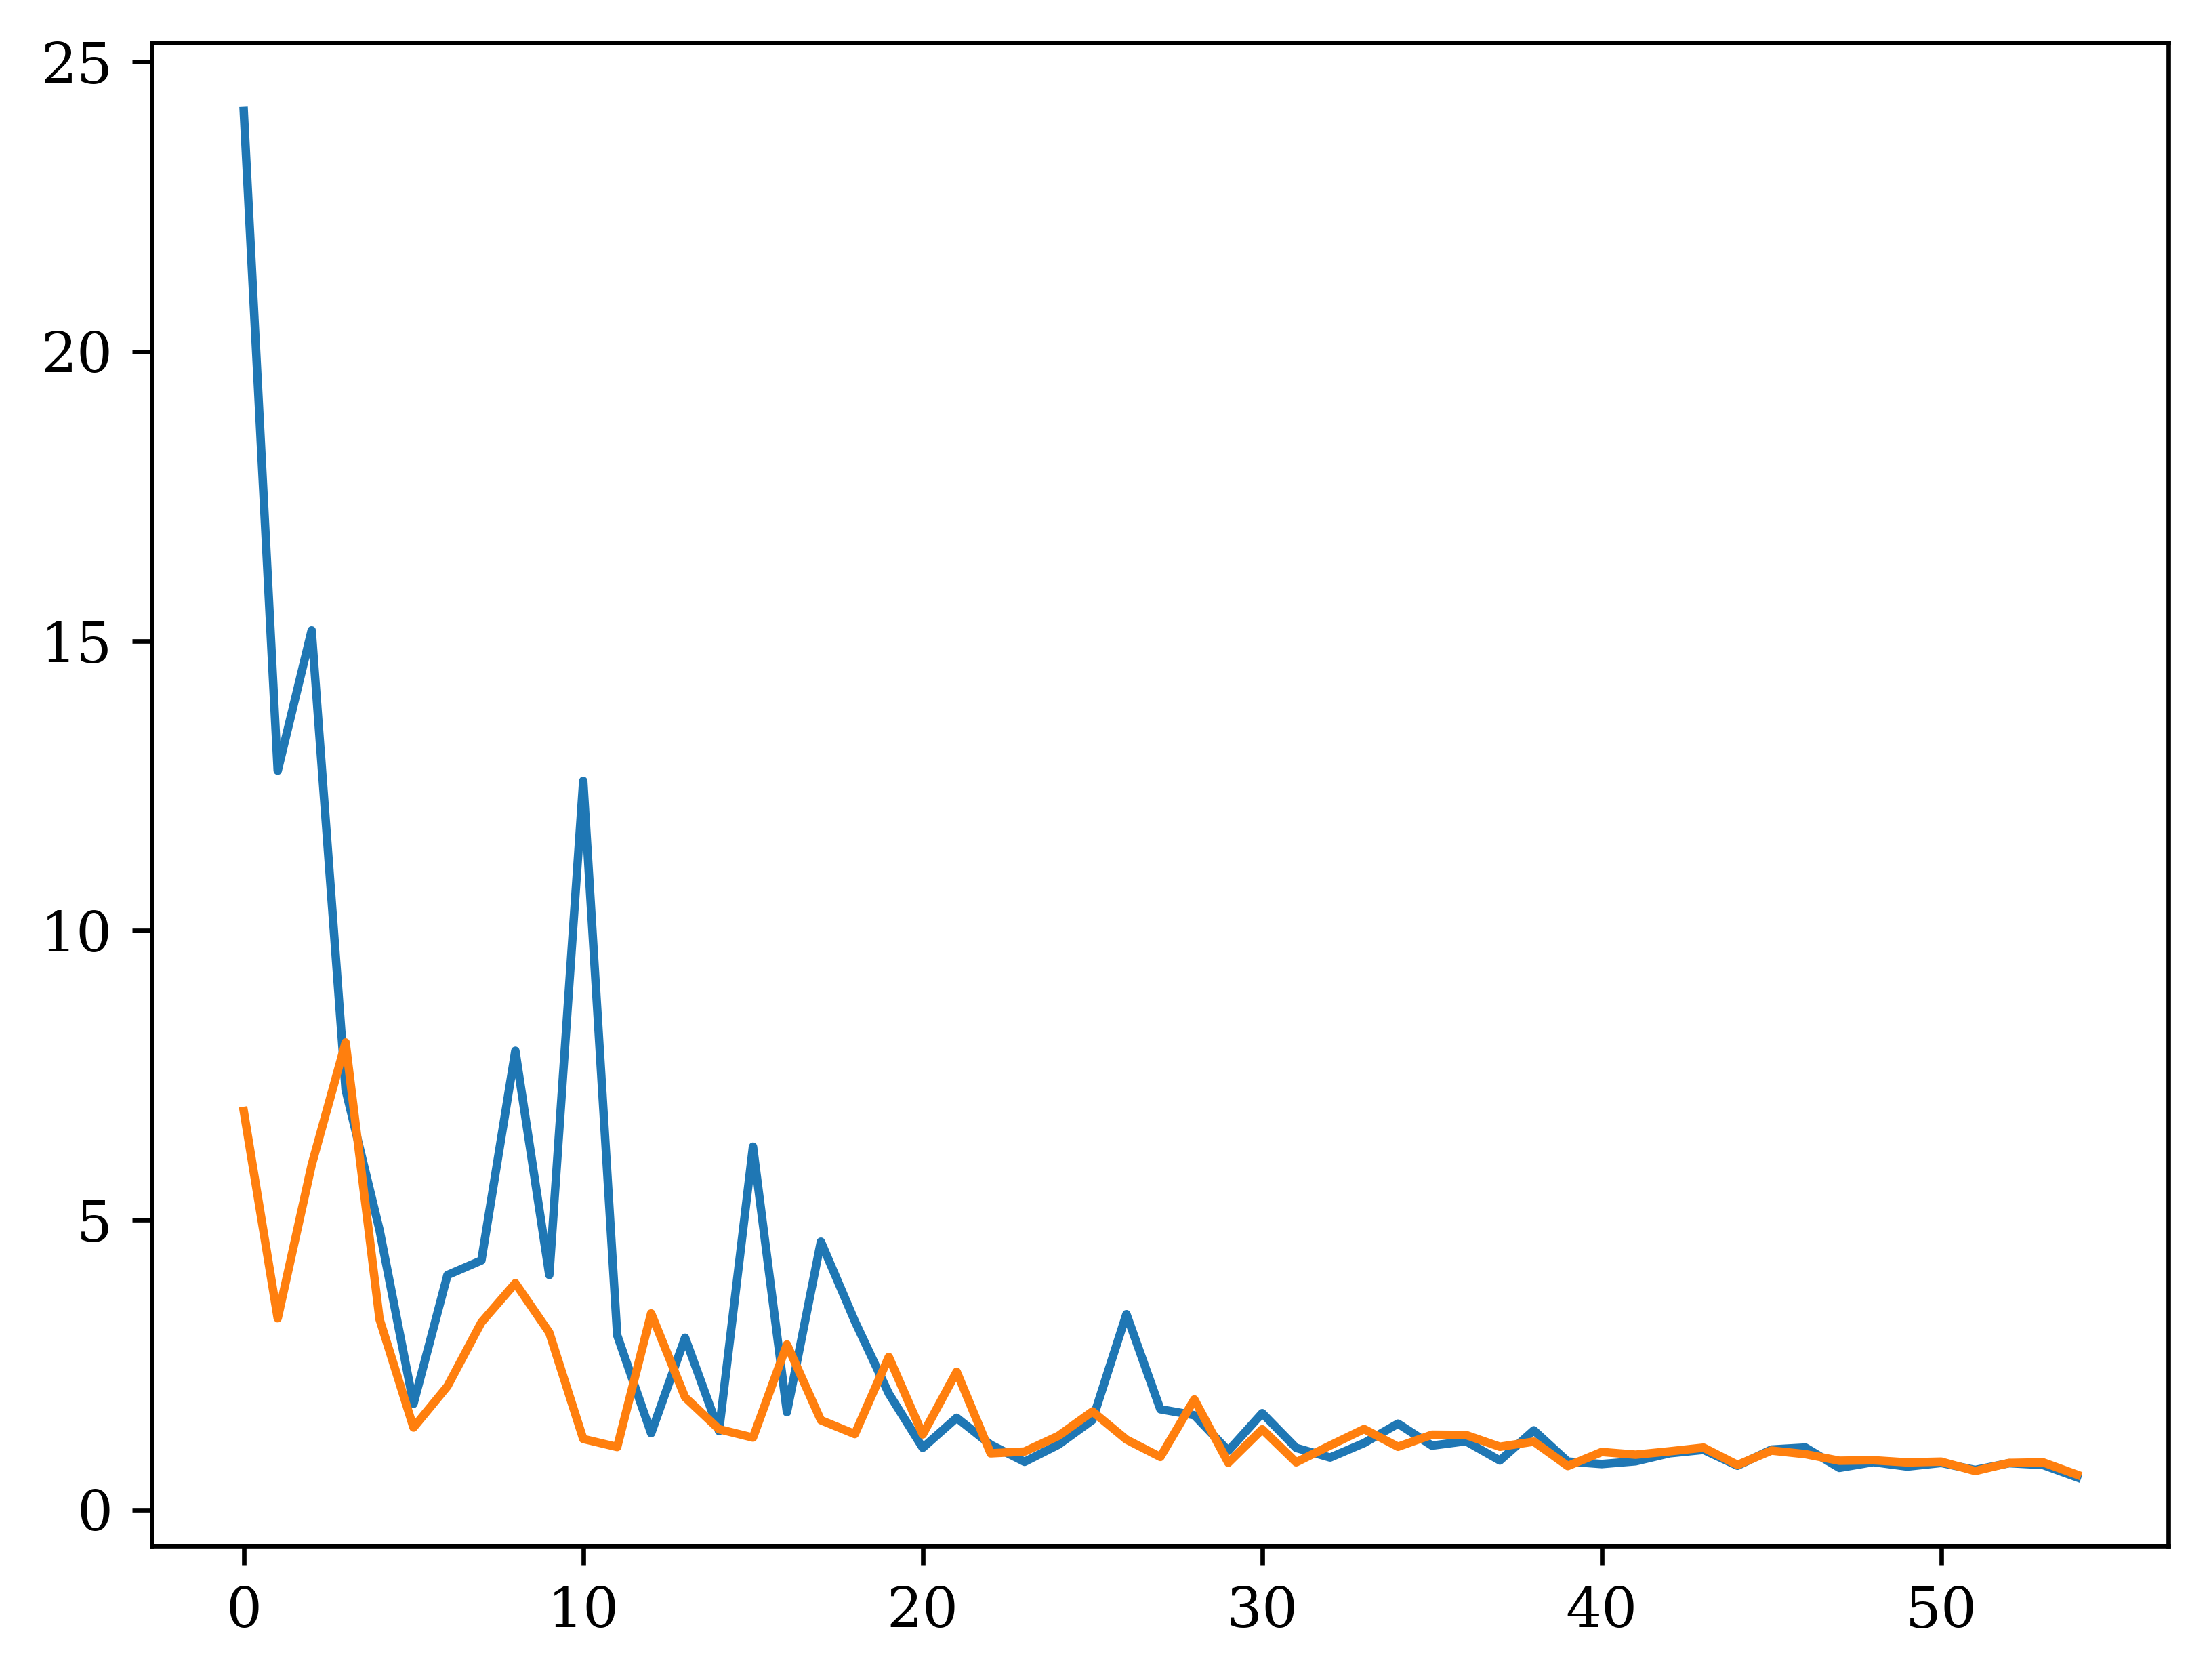

In [45]:
plt.plot(concentration_components['bio'][:, 750])
plt.plot(np.mean(concentration_components['size'], axis=1))

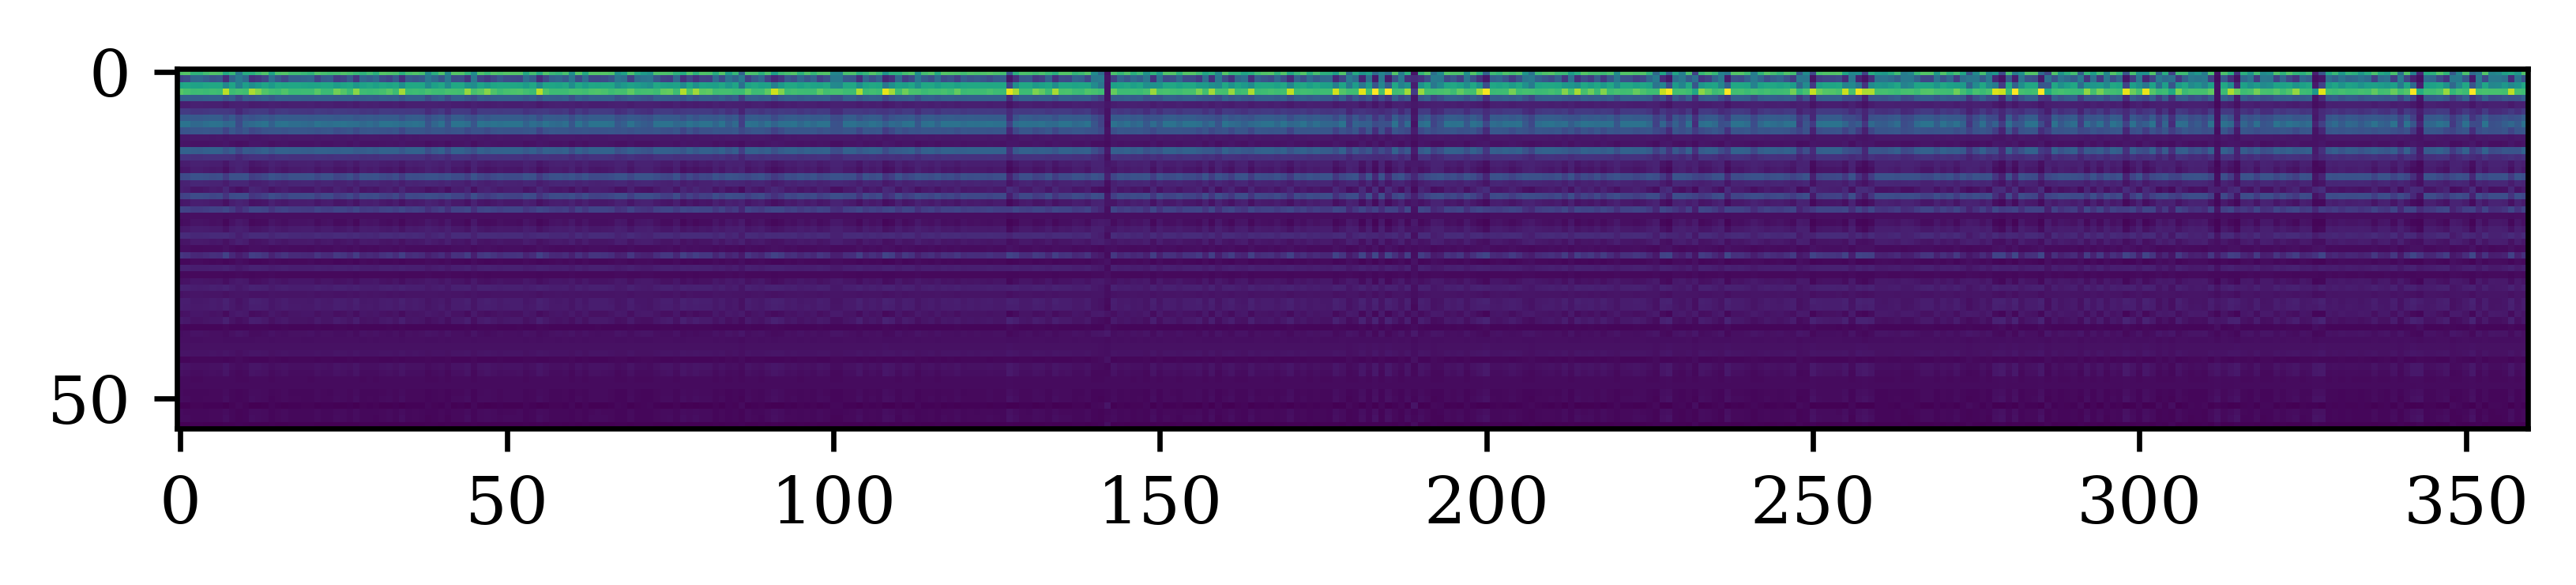

In [40]:
# TODO: make sure I'm handling the transformations of each concentration component correctly
plt.imshow(concentration_components['size'])

In [20]:
def concentration_interpolation(x, conc):
    return jnp.interp(x, jnp.linspace(0, 1, 1000), conc)
concentration_interpolation = vmap(concentration_interpolation, in_axes=(0, 0))

In [11]:
def predicted_counts(concentration, total_counts):
    return concentration / concentration.sum() * total_counts
predicted_counts = vmap(predicted_counts, in_axes=(0, 0))

In [15]:
output['bio_ages'].shape

(360,)

In [21]:
out = concentration_interpolation(output['init_components'].age_normalizer(output['bio_ages']), output['concentrations'])

ValueError: xp and fp must be one-dimensional arrays of equal size

In [25]:
concs = []
for i in range(len(output['bio_ages'])):
    idx = i if len(concentrations) > 1 else 0
    _concs = concentration_interpolation(output['init_components'].age_normalizer(output['bio_ages'][i]), concentrations[idx])
    concs.append(_concs)
concs = jnp.array(concs)
preds = predicted_counts(concs, total_counts)

concs.shape, preds.shape

((360, 55), (360, 55))

In [26]:
total_r2 = r2_score(features["counts"], preds, multioutput="variance_weighted")
total_r2

0.5322376466326519

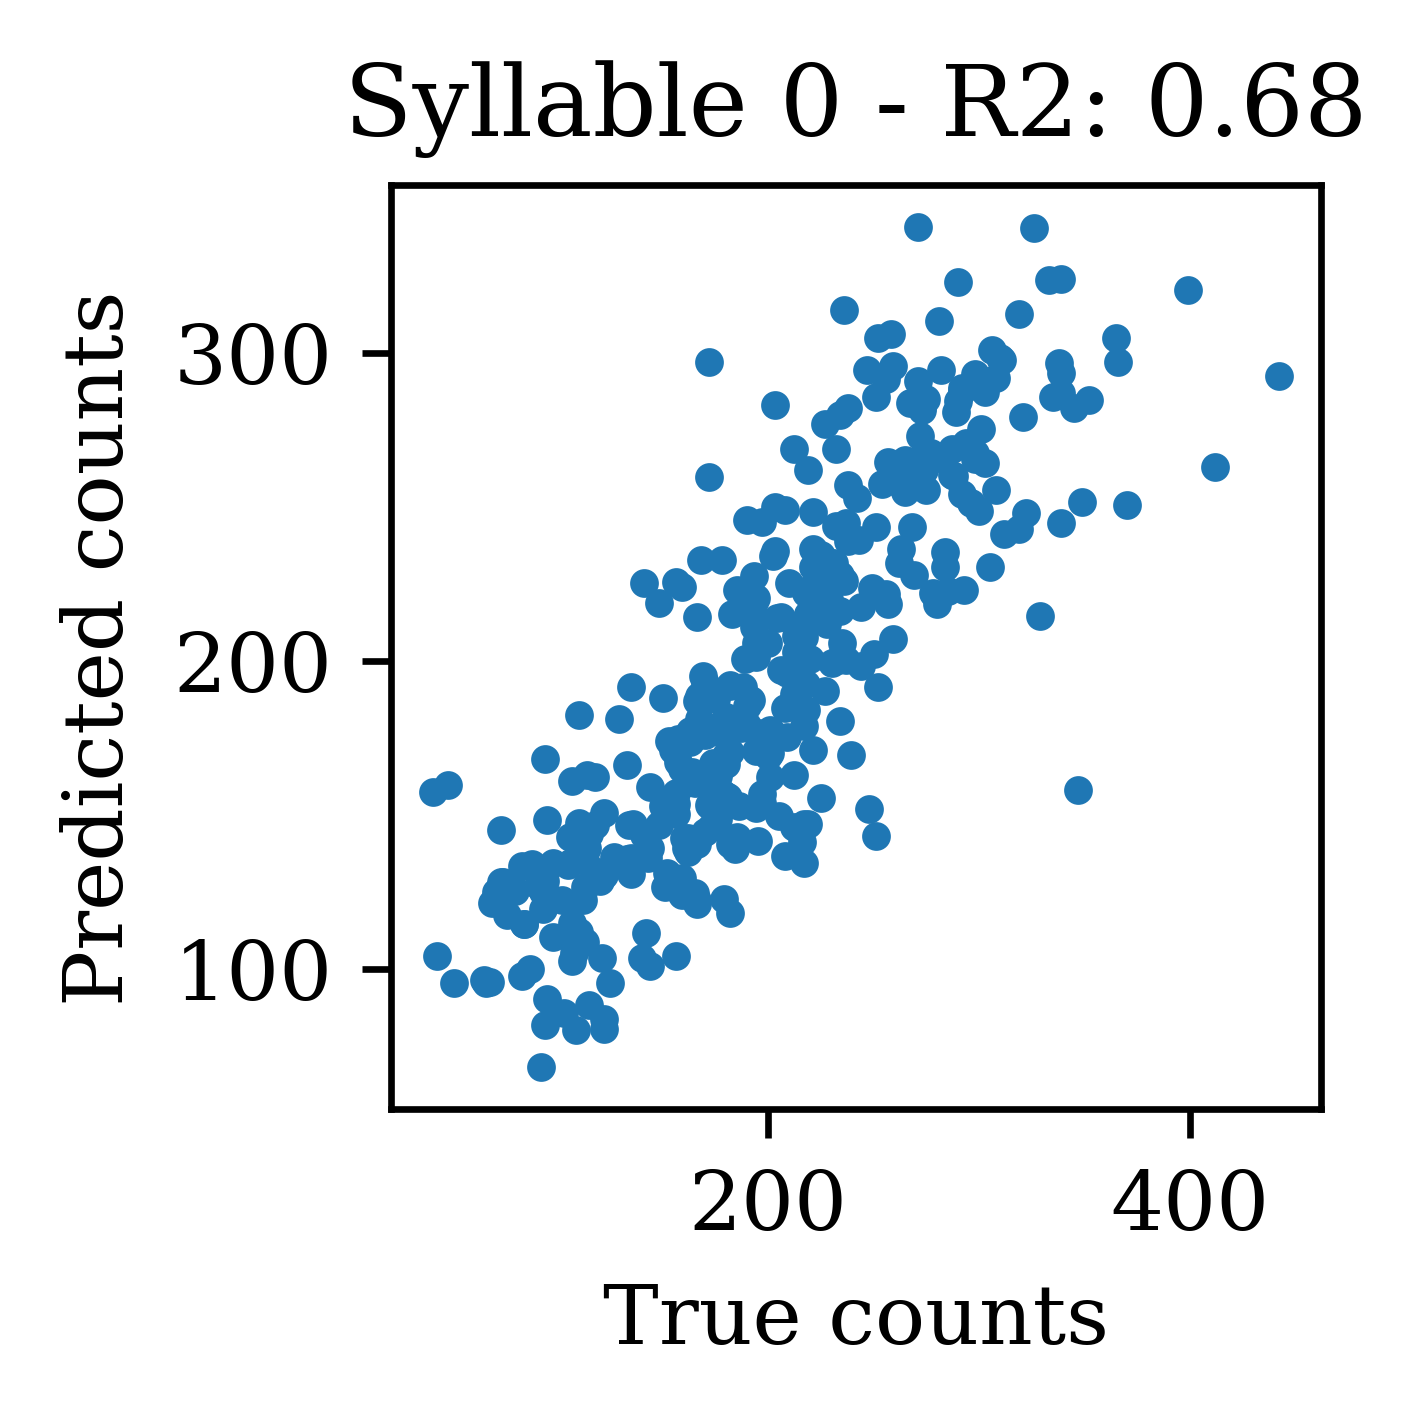

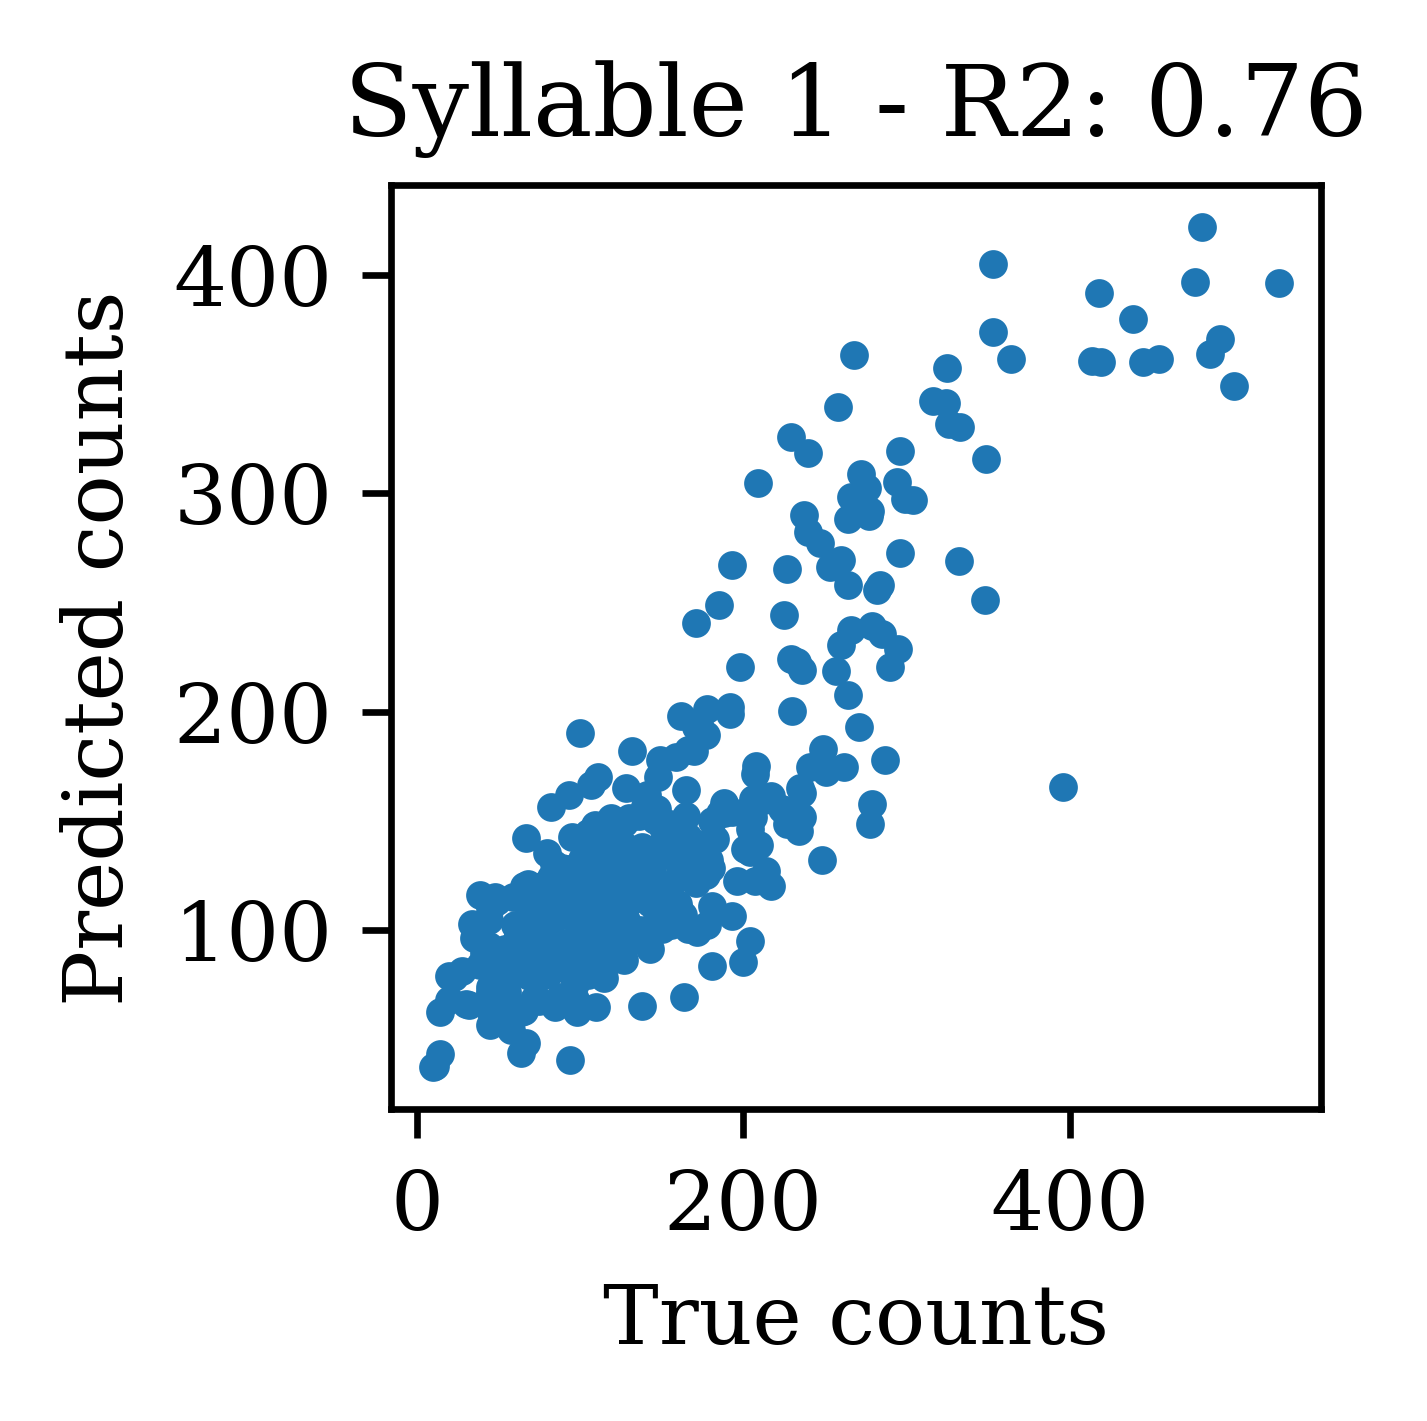

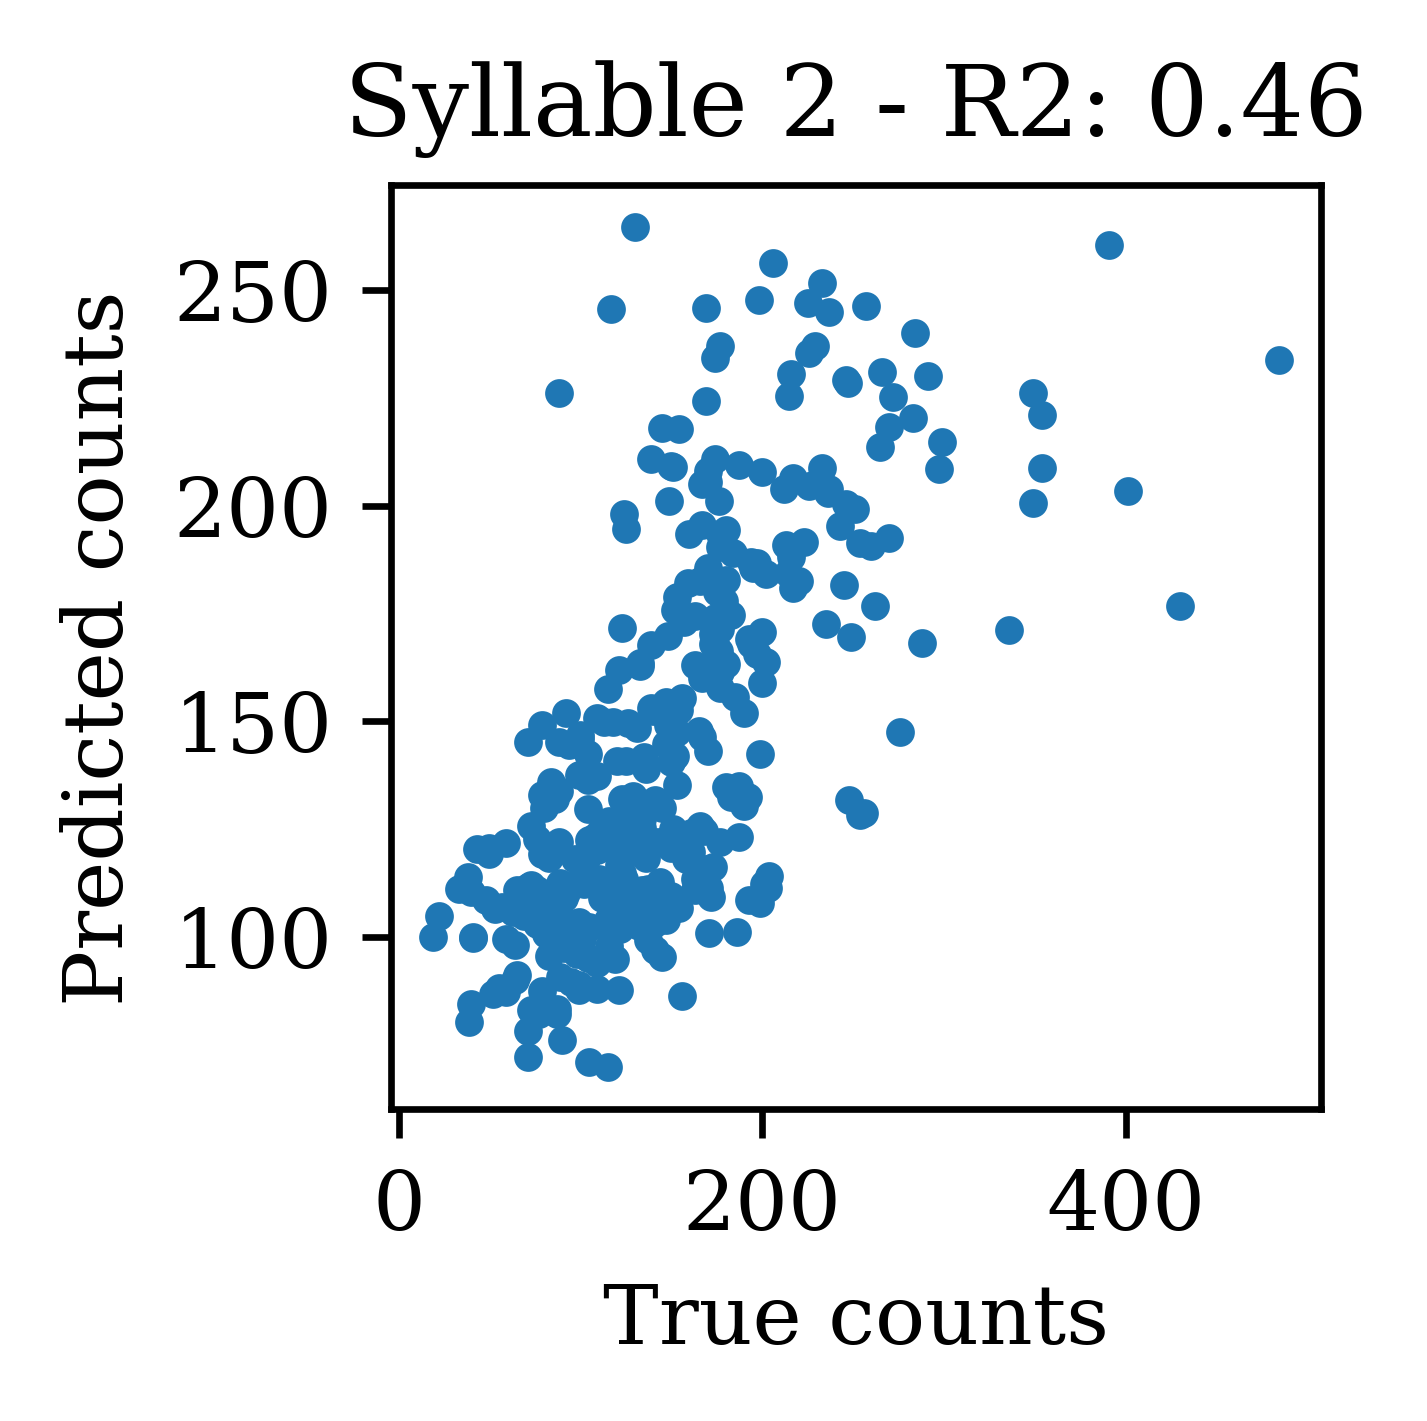

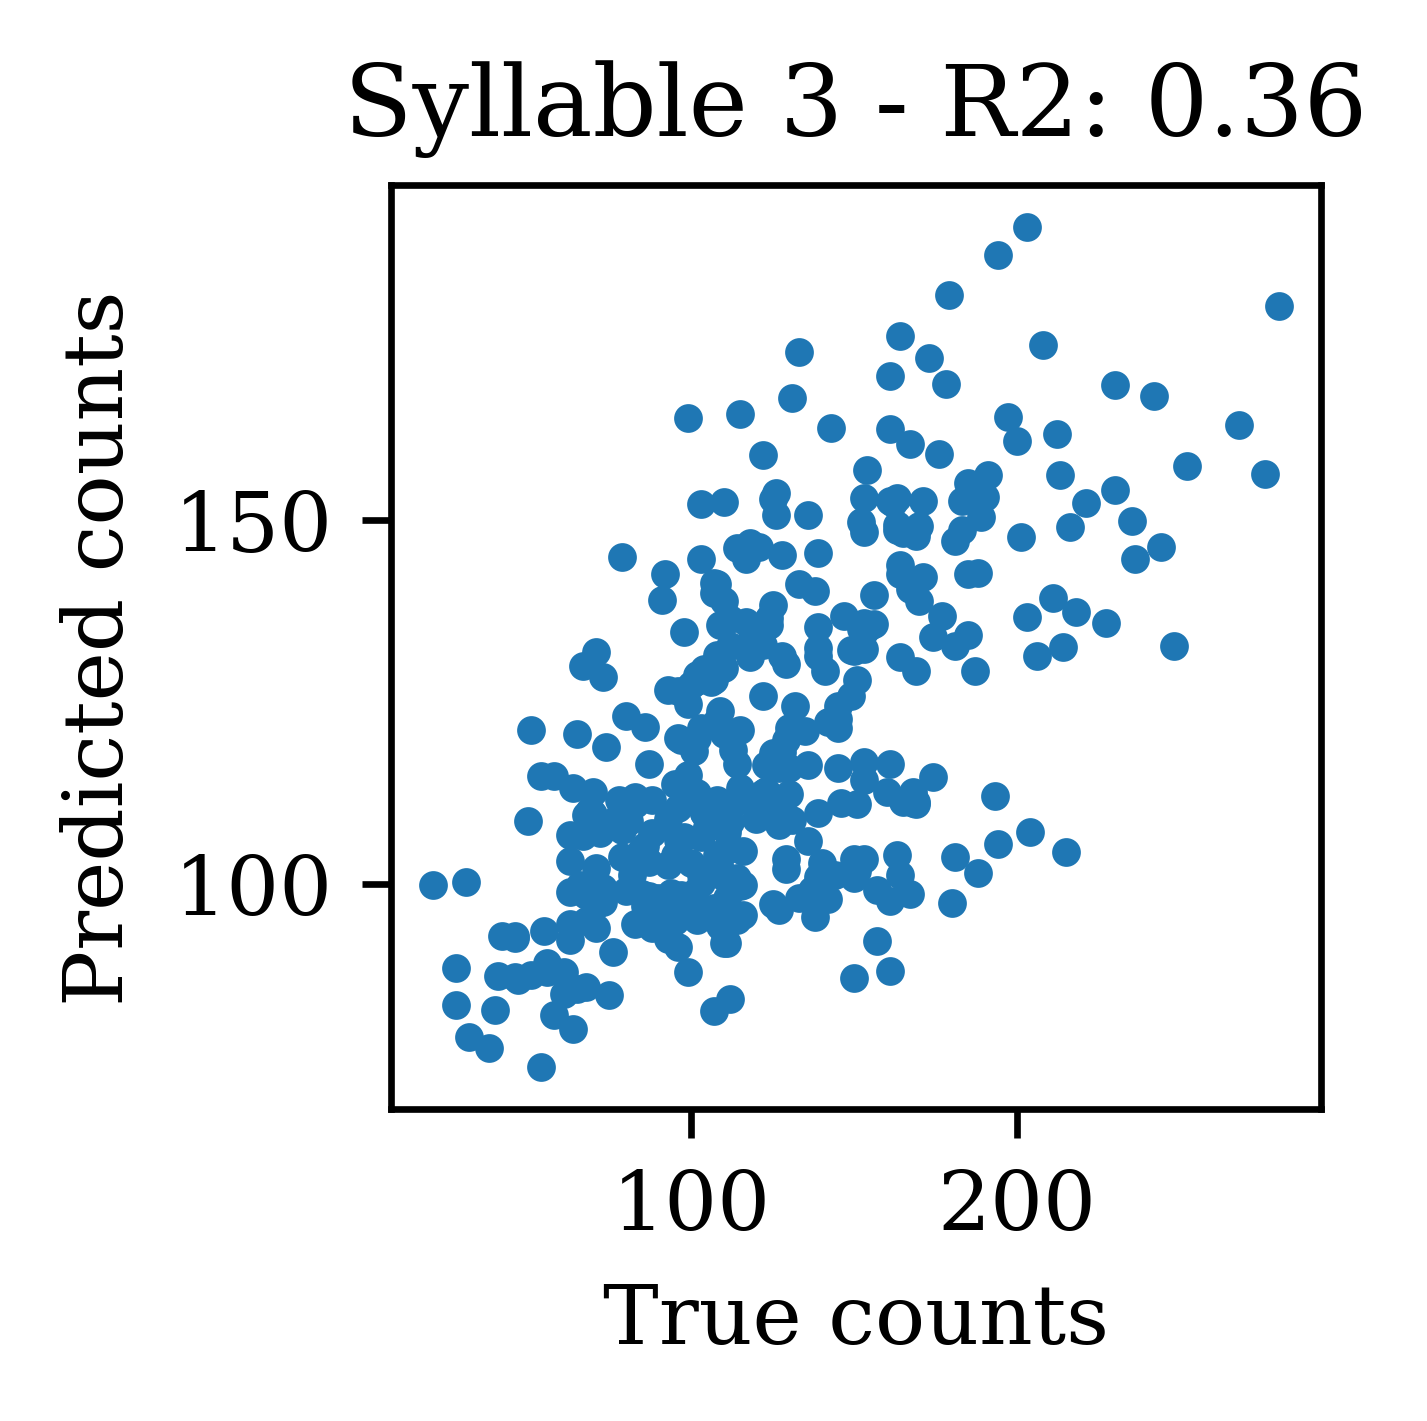

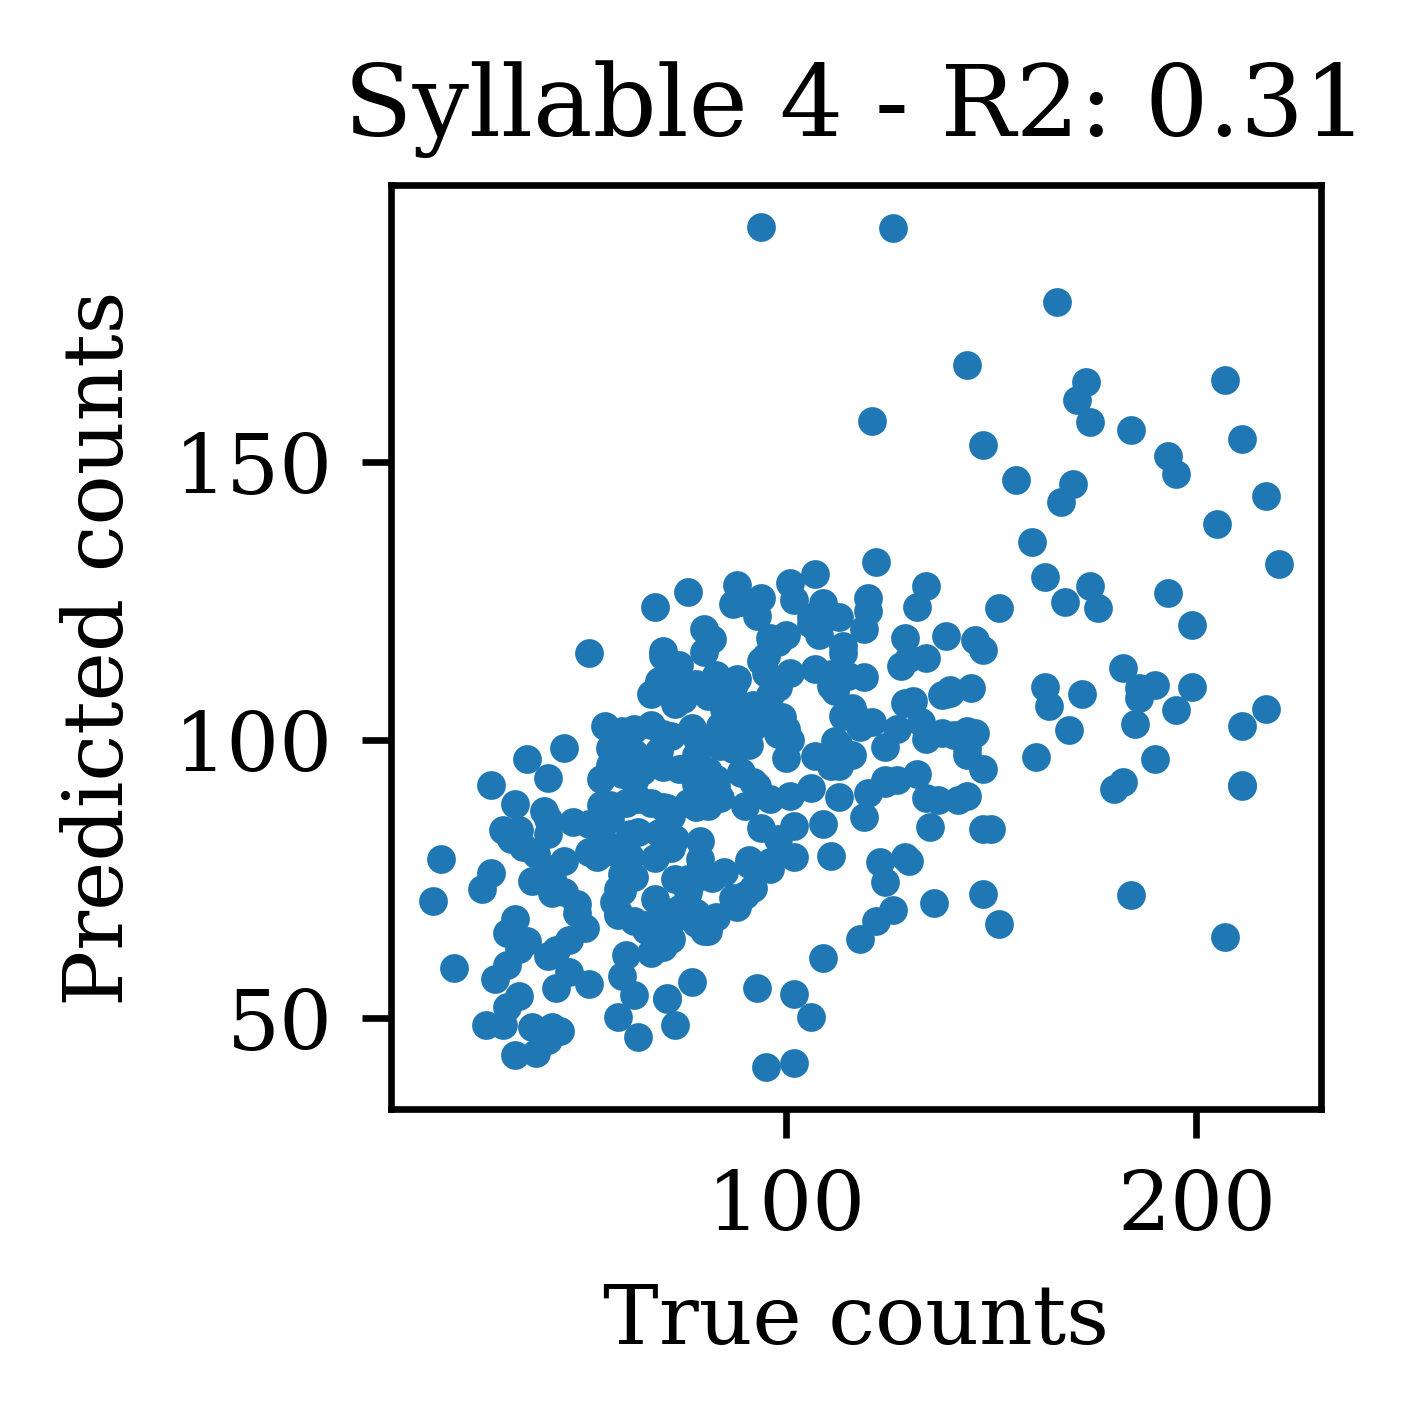

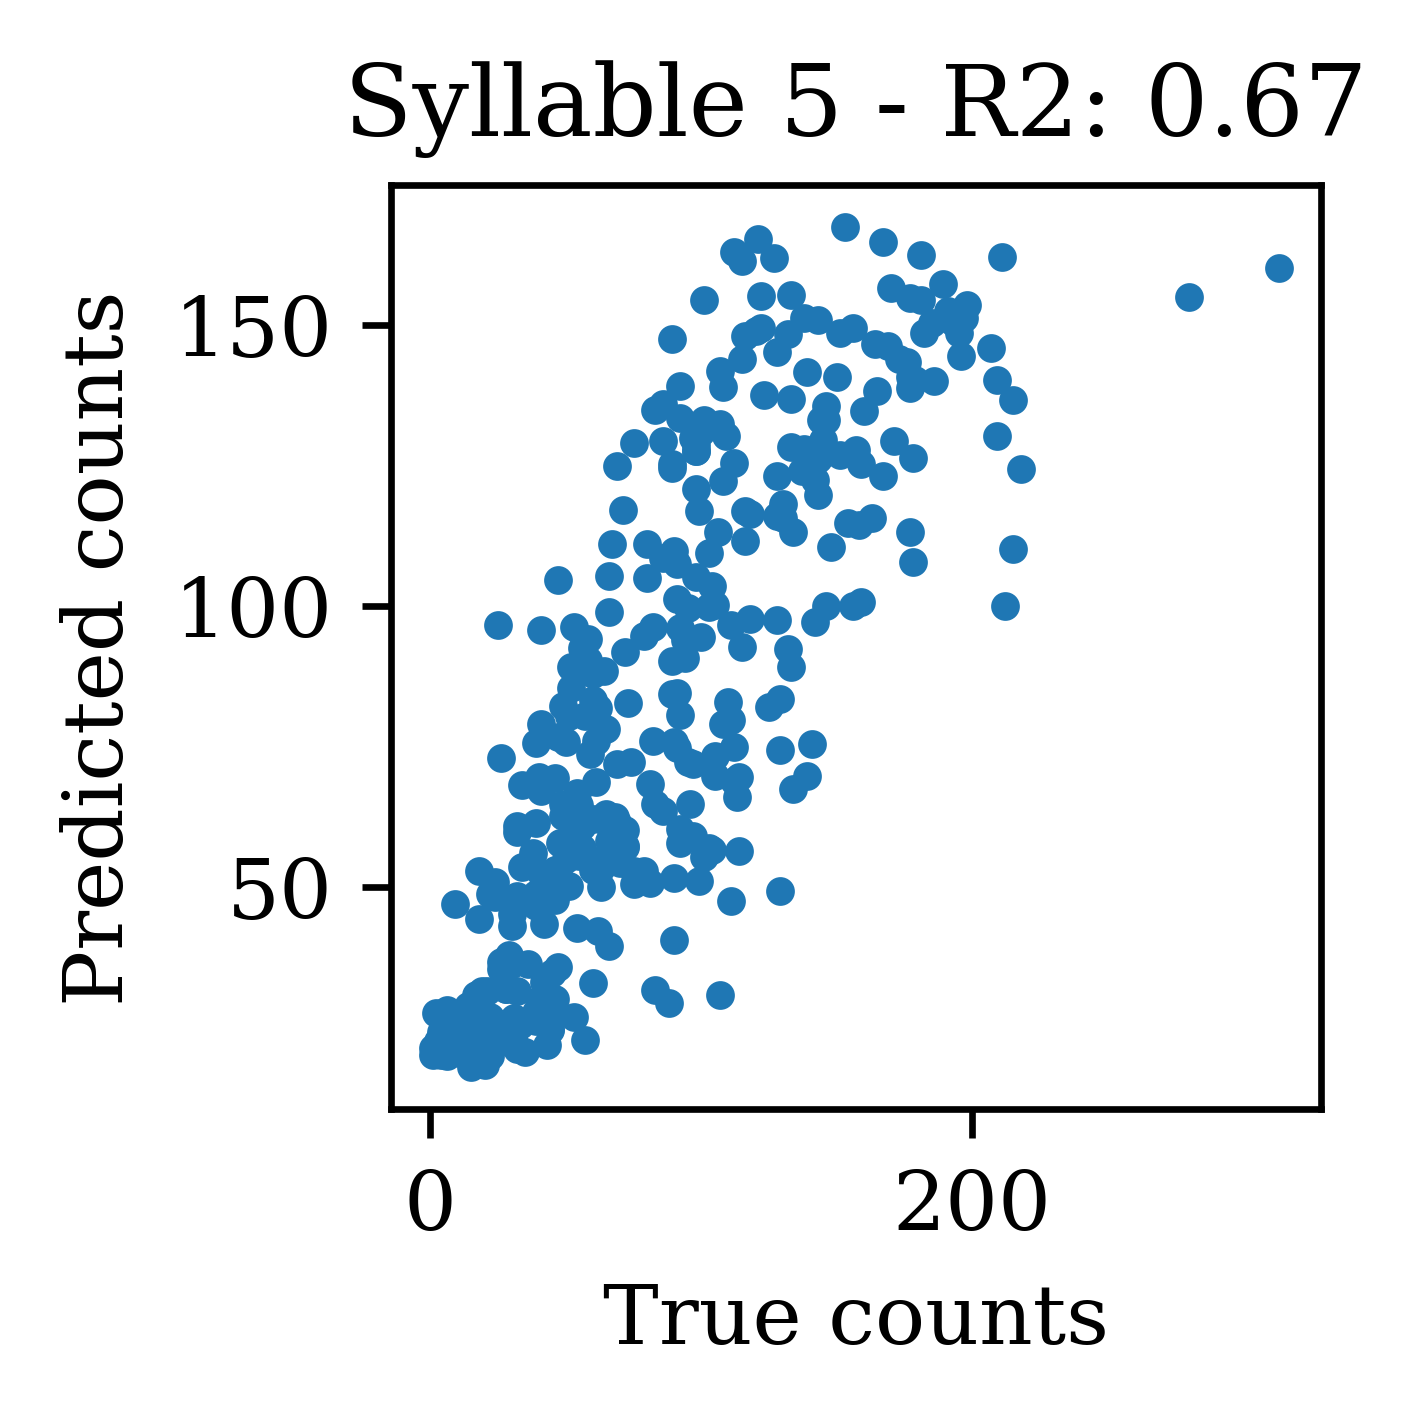

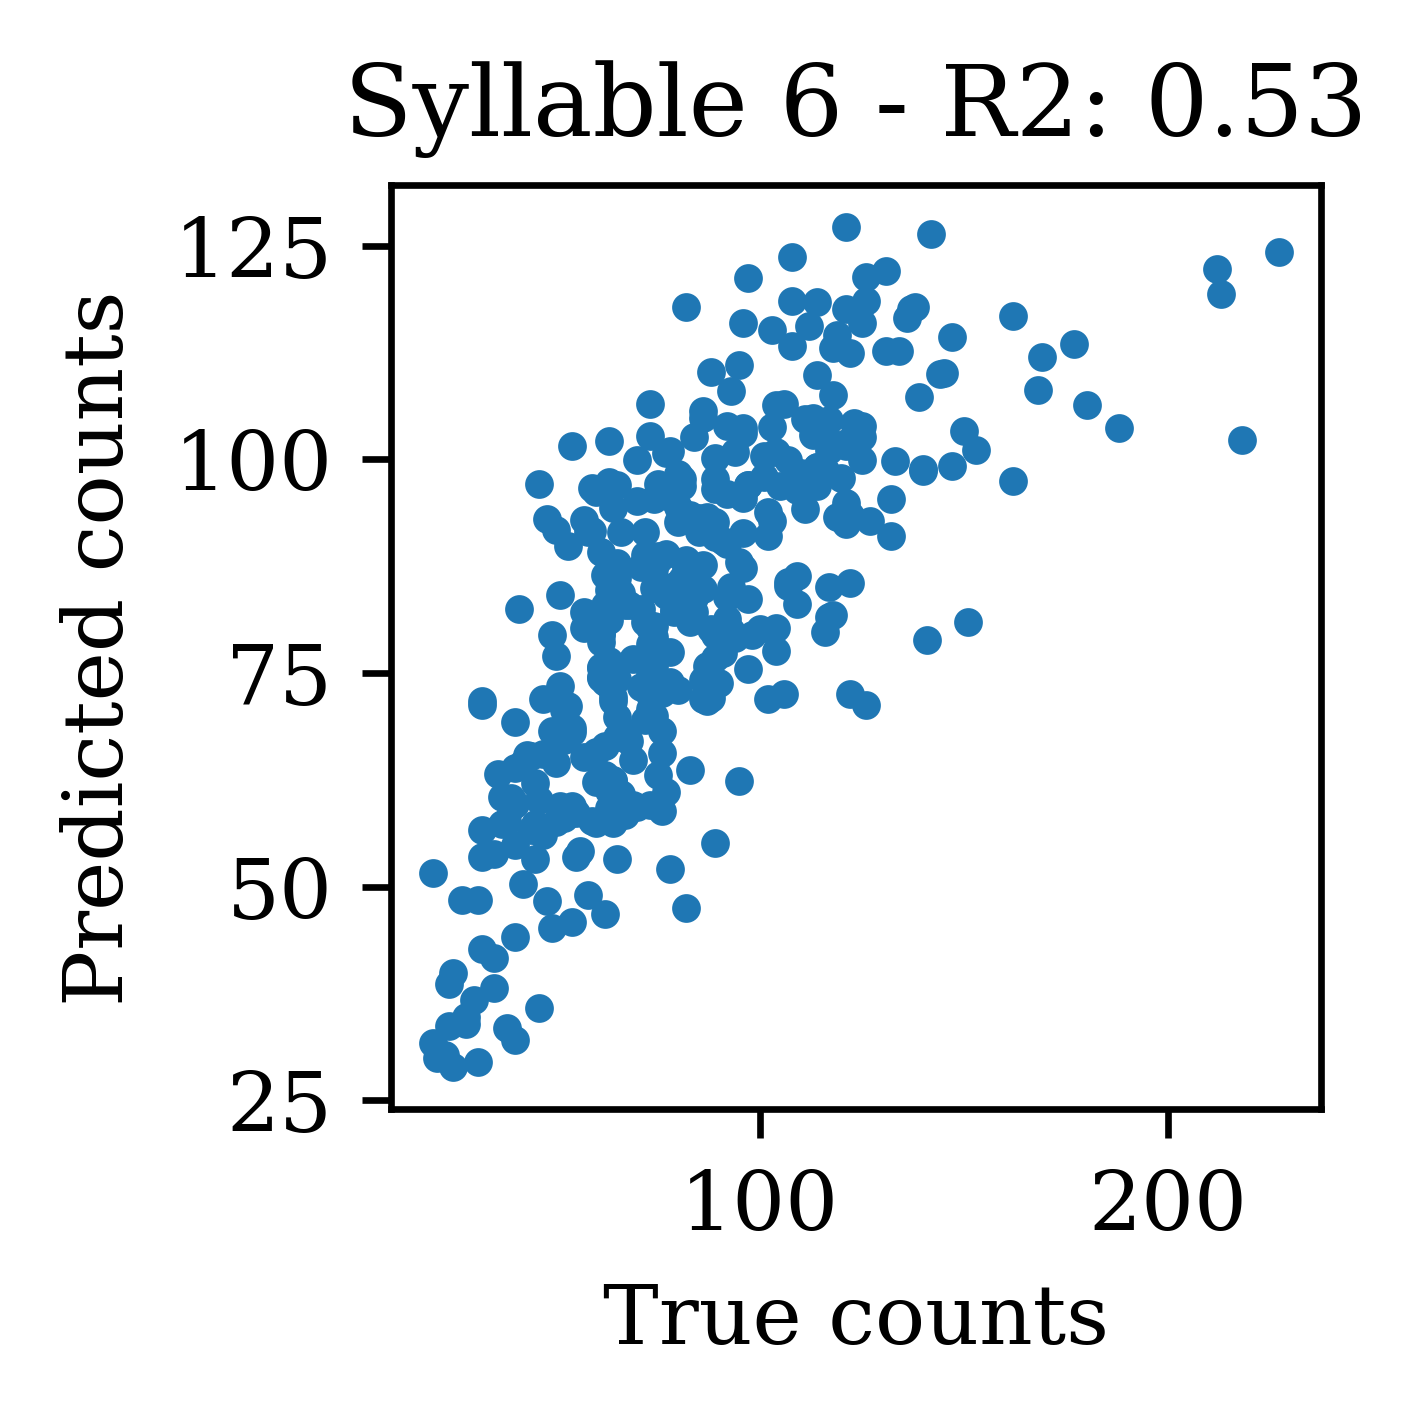

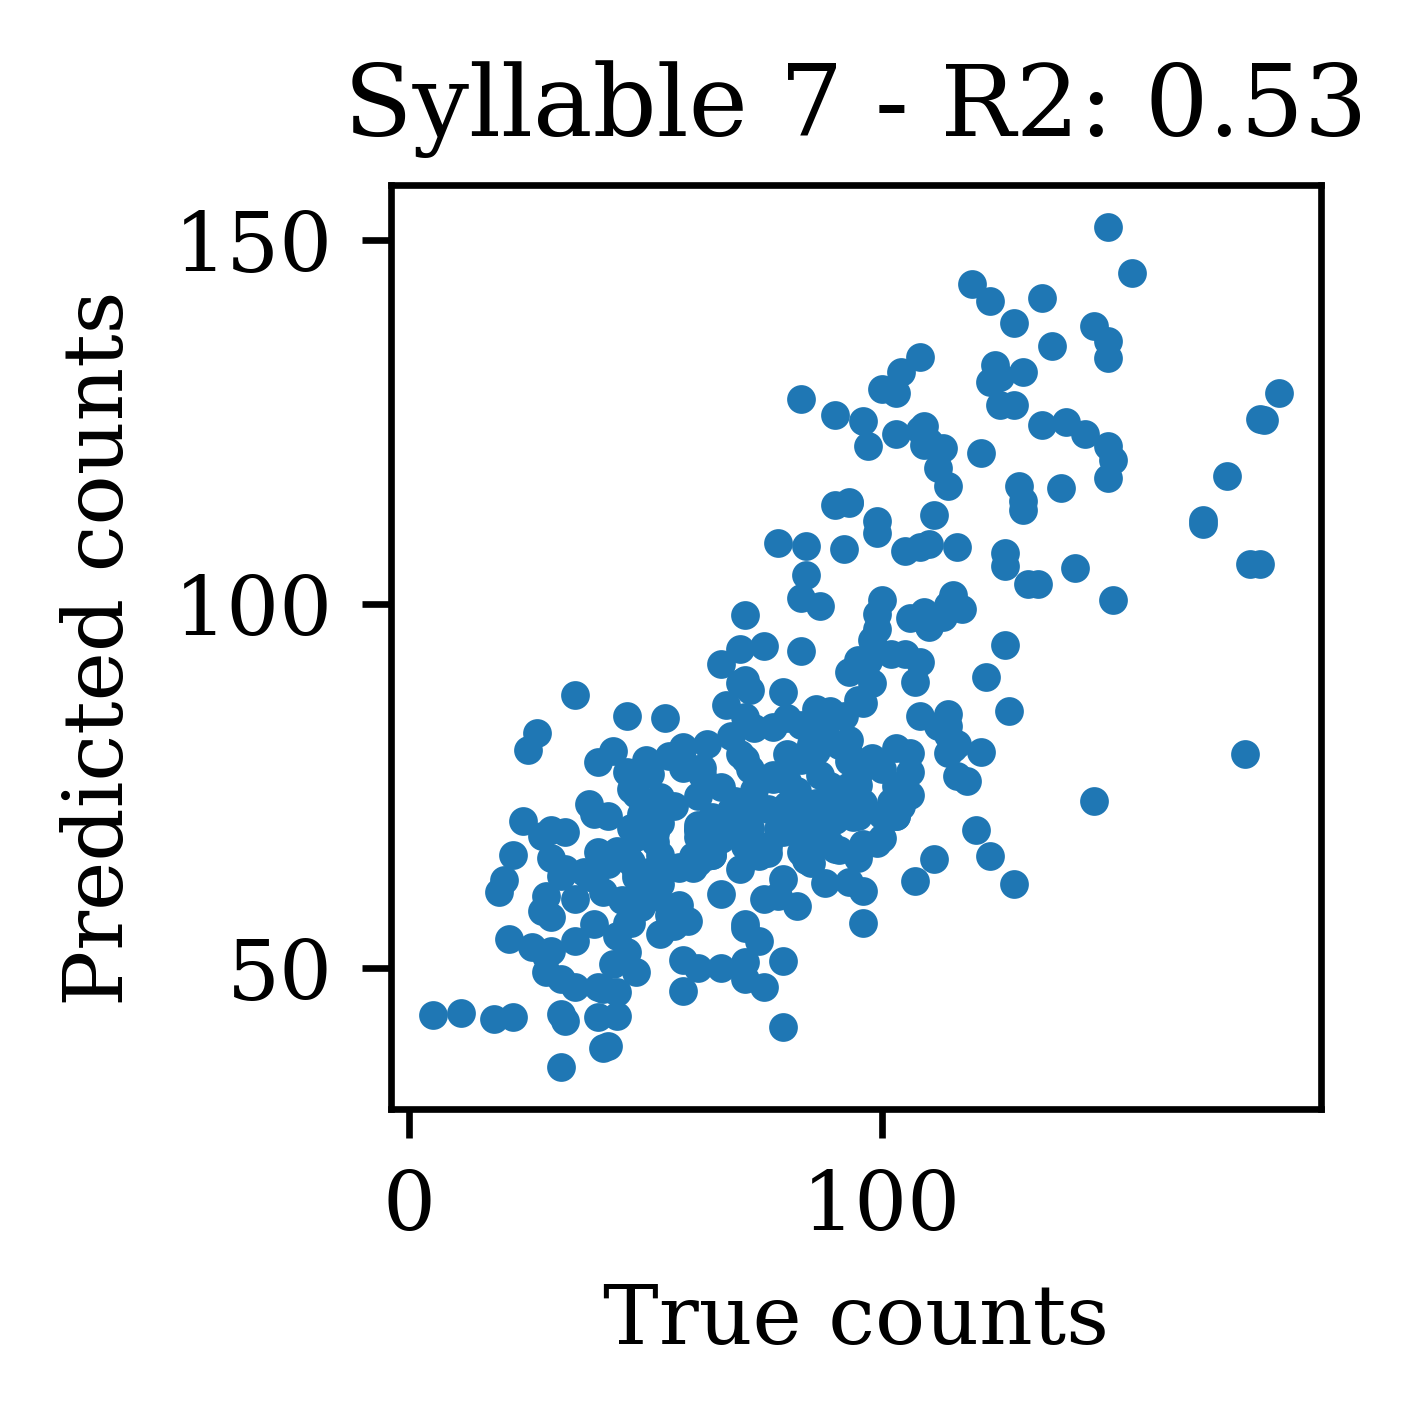

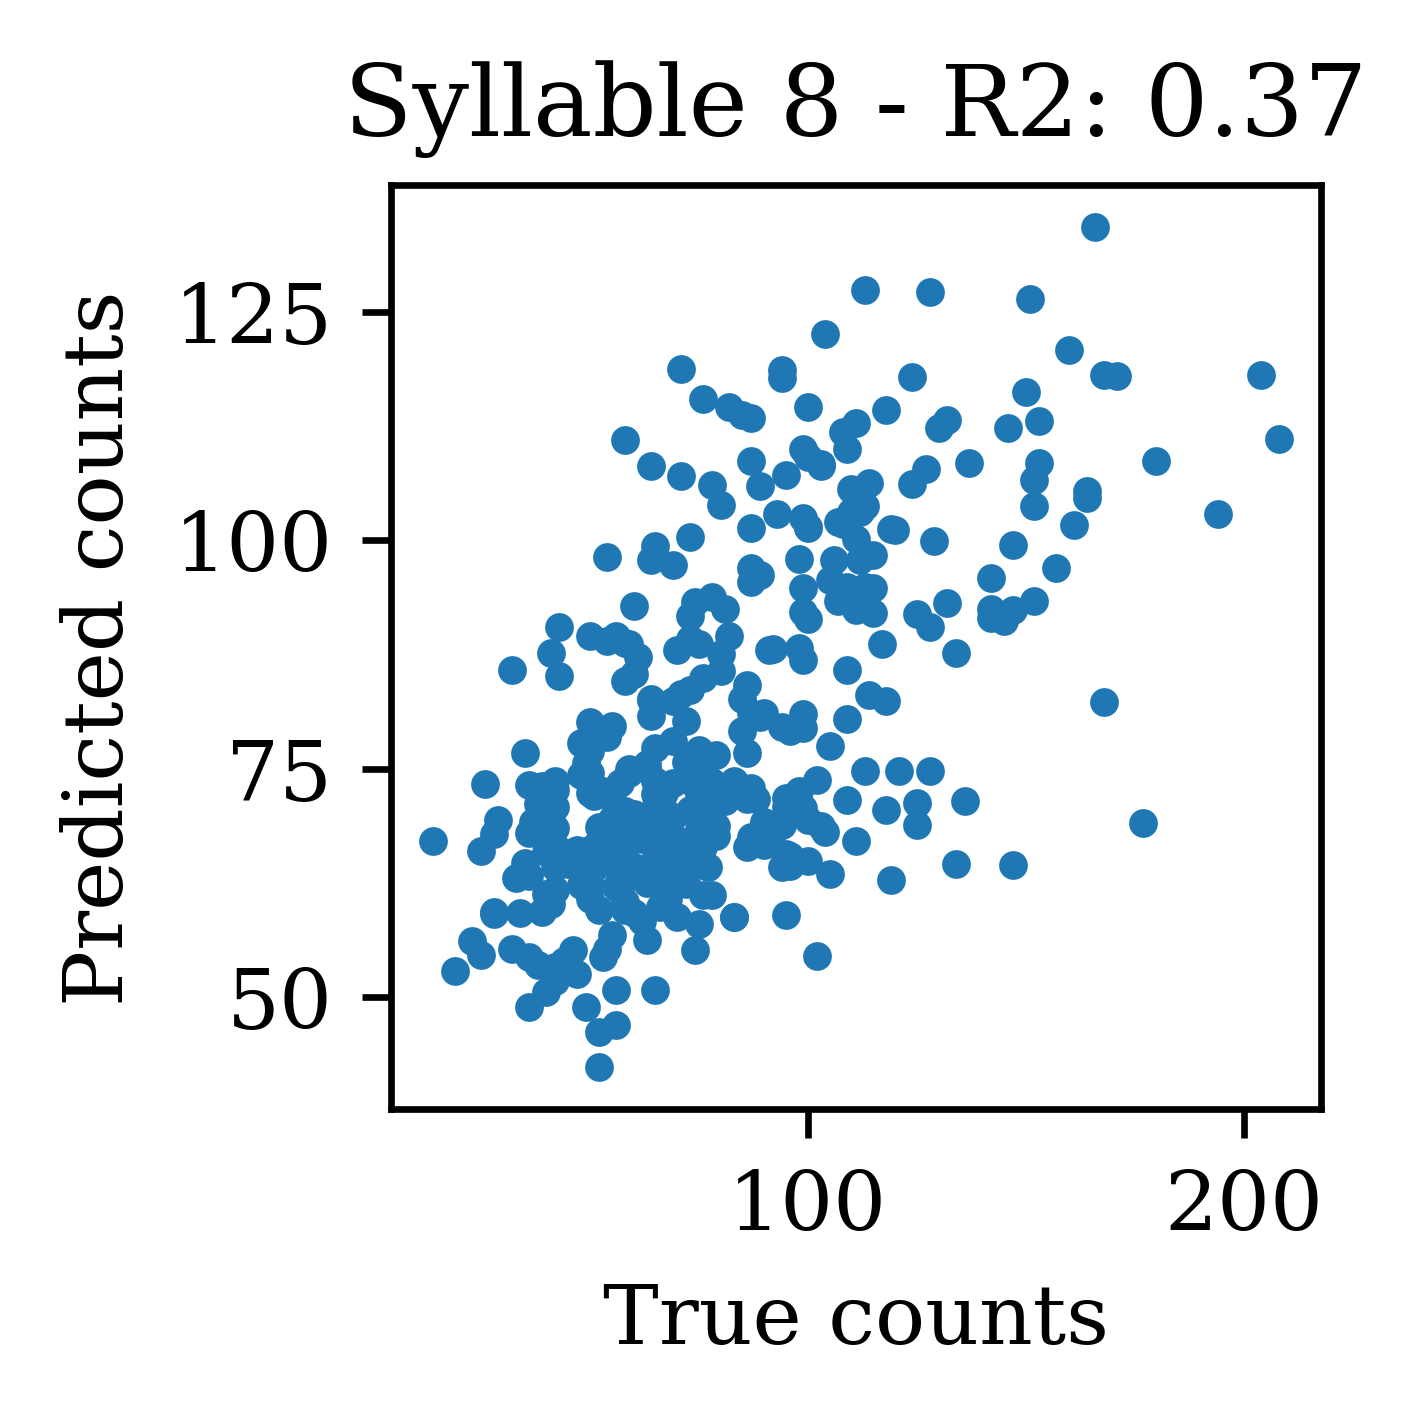

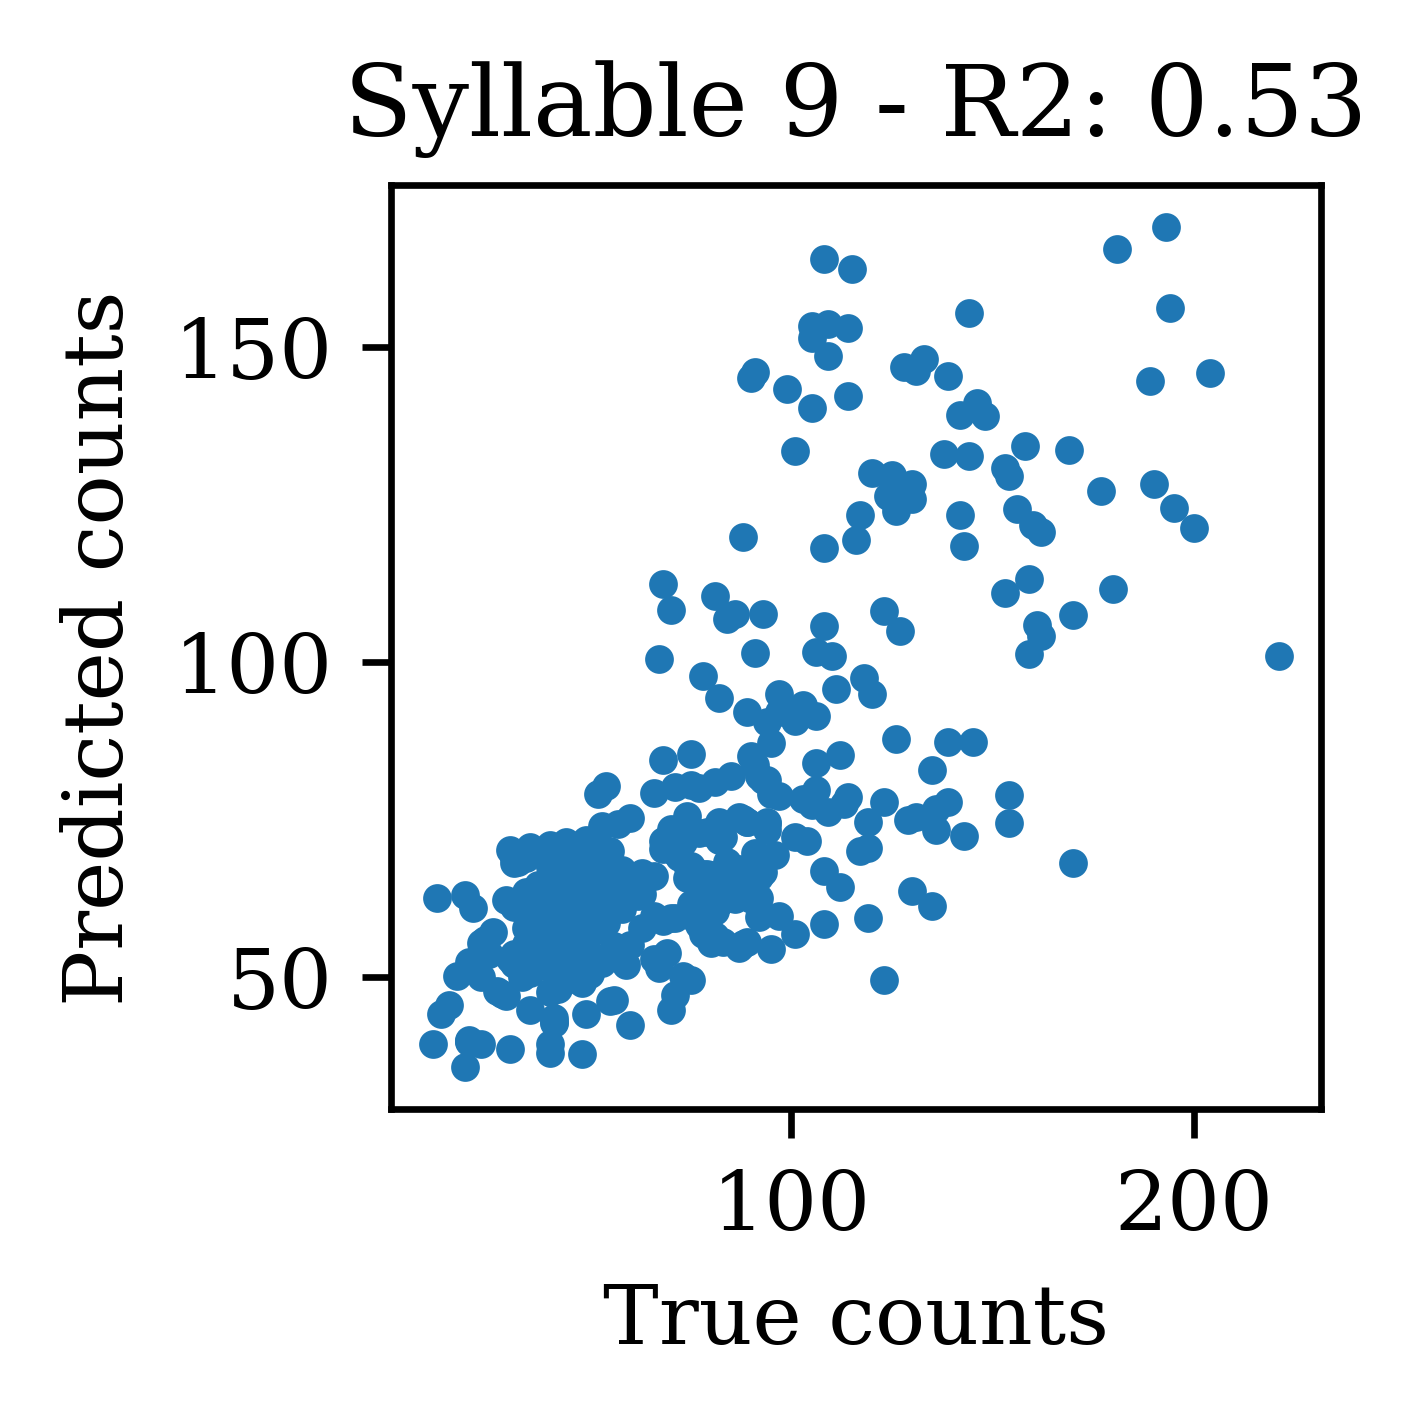

In [27]:
for syllable in range(10):
    plt.figure(figsize=(2, 2))
    _r2 = r2_score(features["counts"][:, syllable], preds[:, syllable])
    plt.scatter(features["counts"][:, syllable], preds[:, syllable], s=6)
    plt.title(f"Syllable {syllable} - R2: {_r2:0.2f}")
    plt.xlabel("True counts")
    plt.ylabel("Predicted counts")

## Compare to linear model

In [29]:
from sklearn.linear_model import LinearRegression

In [30]:
mdl = LinearRegression()

In [33]:
mdl.fit(features['ages'].reshape(-1, 1), features['counts'])

LinearRegression()

In [34]:
p = mdl.predict(features['ages'].reshape(-1, 1))

In [37]:
r2_score(features["counts"], p, multioutput="variance_weighted")

0.17290230630539846